In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **0. Import Packages**

In [ ]:
from typing import List, Tuple

import pandas as pd
import numpy as np
import operator

import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [ ]:
seed = 123

## **1. Data Preparing**

### 1.1 Read in Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/BT5153Applied Machine Learning/Data/train_data_autorec.csv", index_col = 0)
for col in df.columns:
  df[col] = df[col].astype(np.int8)
df.head()

,Savings_Acct,Guarantees,Cur_Acct,Derivative_Acct,Payroll_Acct,Junior_Acct,Mas_Particular_Acct,Particular_Acct,Particular_Plus_Acct,Short_Term_Deposits,...,Mortgage,Pension1,Loans,Taxes,Credit_Card,Securities,Home_Acct,Payroll,Pension2,Direct_Debit
Cust_ID,,,,,,,,,,,,,,,,,,,,,
15889,0,0,6,0,0,0,0,0,6,0,...,0,0,0,0,3,6,0,0,0,0
15890,0,0,0,0,6,0,0,0,6,0,...,0,6,0,0,6,0,0,6,6,6
15892,0,0,6,0,0,0,0,0,0,0,...,0,0,0,6,6,6,0,0,0,6
15893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6,0,0,0,0
15894,0,0,6,0,0,0,0,0,0,0,...,0,0,0,6,6,6,0,6,6,6


In [ ]:
df_count = pd.DataFrame(df.astype(bool).sum(axis=1), columns=["count of product rates"])
df_count.groupby(['count of product rates']).size()

count of product rates
1     439350
2     123751
3      50811
4      33537
5      22676
6      15706
7      10627
8       5944
9       2692
10      1061
11       381
12        87
13        26
14         2
15         1
dtype: int64

### 1.2 Split Train Test

In [ ]:
def preprocess_data(data: pd.DataFrame, test_size: float = 0.1, random_state: int = seed):
  num_users = len(data)
  num_items = len(data.columns)

  train_mat, val_mat = train_test_split(data, test_size=test_size, random_state=random_state)

  return train_mat, val_mat, num_users, num_items

In [ ]:
train_val, test, _, _ = preprocess_data(df)
train, val, num_users, num_items = preprocess_data(train_val)

In [ ]:
# not all data in test has ground truth label, so we need to filter out the data that has no label, so that we can calculate the Hit Ratio
test_label = pd.read_csv("/content/drive/MyDrive/BT5153Applied Machine Learning/Data/test_data_ground_truth_autorec.csv", index_col = 0)
test_index = [i for i in test.index if i in test_label.index]
test_label = test_label.loc[test_index,:]
test = test.loc[test_index, :]

### 1.3 Load Data to DataLoader

In [ ]:
class AutoRecData(data.Dataset):
    r"""_summary_
    Parameters
    ----------
    data : DataFrame
        A two-dimensional list is required.
    """

    def __init__(self, data) -> None:
      super(AutoRecData, self).__init__()

      self.data_df = data
      self.data_np = data.to_numpy()
      self.users = data.index
      self.items = len(set(self.data_np.nonzero()[1]))

    def __len__(self) -> int:
      return len(self.data_np)

    def __getitem__(self, index) -> None:
      return self.data_np[index]
    
    def get_user(self, user_id):
      return self.data_df[self.data_df.index == user_id].values.reshape(self.items,)

train_set = AutoRecData(data=train)
val_set = AutoRecData(data=val)
test_set = AutoRecData(data=test)

train_loader = data.DataLoader(
        dataset=train_set,
        batch_size=256,
        shuffle=True,
    )
val_loader = data.DataLoader(
    dataset=val_set, batch_size=256, shuffle=False
)

test_loader = data.DataLoader(
    dataset=test_set, batch_size=256, shuffle=False
)

## **2. Auto Encoder**

### 2.1 Define Model and Loss Function

In [ ]:
class AE(nn.Module):
  """
  Auto Encoder (AE) was originally used to learn the representation (encoding) of data. It can be broken down into two parts:

  encoder: reduces the dimension size of the data;
  decoder: It converts the encoding back to its original form. Due to dimensionality reduction, neural networks need to learn a low-dimensional representation of the input (latent space) in order to be able to reconstruct the input.

  They can be used to predict new recommendations. In order to do this, both input and output are vectors (usually the input and output of AE are the same), and we will use a large dropout after the input layer.
  This means that the model will have to reconstruct the vector, because some element in the input will be missing, and thus learn to predict the recommendation value given the click vector.
  """
  def __init__(self, nb_products, device="cuda:0"):
    super(AE, self).__init__()
    self.nb_products = nb_products
    self.encoder = nn.Sequential(
        nn.Linear(self.nb_products, 512),
        nn.Sigmoid(),
        nn.Dropout(0.9), # need a large dropout
        nn.Linear(512, 80),
        nn.Sigmoid(),
        nn.Linear(80, 32),
        nn.Sigmoid()
        )
    self.decoder = nn.Sequential(
        nn.Linear(32, 80),
        nn.Sigmoid(),
        nn.Linear(80, 512),
        nn.Sigmoid(),
        nn.Linear(512, self.nb_products)
        )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

def loss_func(recon_x, x):
  """
  For a user, he only rated some products, so when calculating MSE, only consider the products he has rated, and ignore the products he has not rated
  The calculation principle of MSE here is, for example, the scoring data of 2 users on 5 products is: [[1, 2, 0, 3, 4], [2, 3, 0, 0, 1]]
  The scoring data after AE reconstruction is: [[1.1, 2.3, 0, 3.3, 4.7], [2.1, 3.2, 0, 0, 1.2]]
  First calculate the square of the 2-norm of the two scoring data, then divide by the number of products scored by each user to get the MSE of each user, and then use torch.mean to average to get the MSE of each batch
  """
  MSE = torch.mean(torch.norm((x - recon_x), p=2, dim=1, keepdim=False)**2/torch.sum(recon_x!=0,axis=1))
  return MSE

### 2.2 Define Train Function

In [ ]:
def train(train_loader, dev_loader=None, is_validate=True, device="cuda:0"):
  ae.train()
  total_loss = 0
  for data in train_loader:
    data = data.float().to(device)
    target = data.clone()
    optimizer.zero_grad()
    recon_x = ae.forward(data)
    # In the optimization process, we only want to consider products that users have rated,
    # Although we previously set the ratings of products not rated by users to 0, we also need to set the ratings of products predicted by the model to 0.
    # In this way, it will not be added to the loss and affect the weight update
    recon_x[target == 0] = 0 
    loss = loss_func(recon_x, data)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
    epoch_train_loss = total_loss / len(train_loader)

  if (is_validate == True):
    ae.eval()
    total_loss = 0
    with torch.no_grad():
      for data in dev_loader:
        data = data.float().to(device)
        target = data.clone()
        recon_x = ae.forward(data)
        recon_x[target == 0] = 0
        loss = loss_func(recon_x, data)
        total_loss += loss.item()
        epoch_dev_loss = total_loss / len(dev_loader)
    print('====> Epoch: {} Training Average loss: {:.4f}, Validating Average loss: {:.4f}'.format(epoch, epoch_train_loss, epoch_dev_loss))
    return epoch_train_loss, epoch_dev_loss

  else:
    print('====> Epoch: {} Training Average loss: {:.4f}'.format(epoch, epoch_train_loss))
    return epoch_train_loss

if __name__ == "__main__":
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  nb_products = len(df.columns)
  ae = AE(nb_products = nb_products).to(device)
  optimizer =  optim.Adam(ae.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  EPOCH = 20
  epoches_train_loss = []
  epoches_dev_loss = []

  print("\n", 20 * "=", "Training Auto Encoder on device: {}".format(device), 20 * "=")
  for epoch in range(1, EPOCH + 1):
    epoch_train_loss, epoch_dev_loss = train(train_loader, dev_loader = val_loader)
    epoches_train_loss.append(epoch_train_loss)
    epoches_dev_loss.append(epoch_dev_loss)


 ==================== Training Auto Encoder on device: cuda:0 ====================
====> Epoch: 1 Training Average loss: 2.0184, Validating Average loss: 1.0449
====> Epoch: 2 Training Average loss: 0.8489, Validating Average loss: 0.6292
====> Epoch: 3 Training Average loss: 0.6539, Validating Average loss: 0.6024
====> Epoch: 4 Training Average loss: 0.6315, Validating Average loss: 0.5919
====> Epoch: 5 Training Average loss: 0.6205, Validating Average loss: 0.5842
====> Epoch: 6 Training Average loss: 0.6126, Validating Average loss: 0.5800
====> Epoch: 7 Training Average loss: 0.6054, Validating Average loss: 0.5712
====> Epoch: 8 Training Average loss: 0.5985, Validating Average loss: 0.5645
====> Epoch: 9 Training Average loss: 0.5873, Validating Average loss: 0.5410
====> Epoch: 10 Training Average loss: 0.5296, Validating Average loss: 0.4293
====> Epoch: 11 Training Average loss: 0.4369, Validating Average loss: 0.3559
====> Epoch: 12 Training Average loss: 0.3957, Validatin

In [ ]:
# save the training model
torch.save(ae.state_dict(), '/content/drive/MyDrive/BT5153Applied Machine Learning/models/AutoEncoder.pkl')

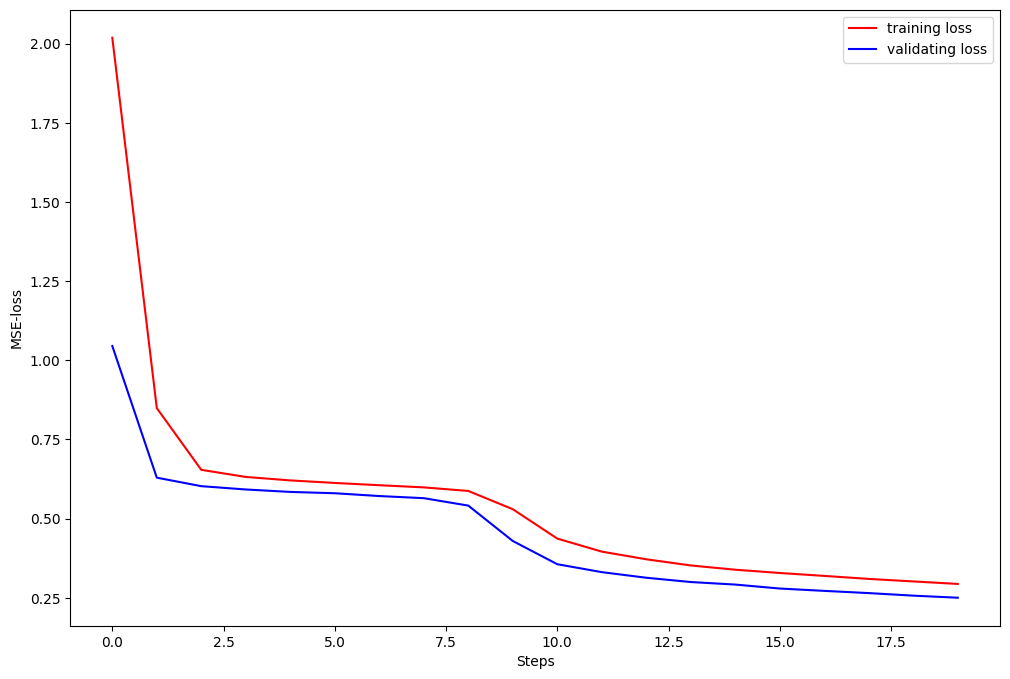

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(np.arange(len(epoches_train_loss)), epoches_train_loss, color='r', label='training loss')
plt.plot(np.arange(len(epoches_dev_loss)), epoches_dev_loss, color='b', label='validating loss')
plt.xlabel('Steps')
plt.ylabel('MSE-loss')
plt.legend()

## **3. Variational Auto Encoder**

### 3.1 Define Model and Loss Function

In [ ]:
class VAE(nn.Module):

  def __init__(self, nb_movies, device="cuda:0"):
    super(VAE, self).__init__()
    self.nb_movies = nb_movies
    self.encoder = nn.Sequential(
        nn.Linear(self.nb_movies, 512),
        nn.Sigmoid(),
        nn.Dropout(0.9), # 需要一个较大的dropout
        nn.Linear(512, 80),
        nn.Sigmoid()
        )
    self.fc1 = nn.Linear(80, 32)
    self.fc2 = nn.Linear(80, 32)
    self.decoder = nn.Sequential(
        nn.Linear(32, 80),
        nn.Sigmoid(),
        nn.Linear(80, 512),
        nn.Sigmoid(),
        nn.Linear(512, self.nb_movies)
        )
    
  # reparameterize
  def reparameterize(self, mu, logvar):
    eps = Variable(torch.randn(mu.size(0), mu.size(1))).to(device)
    z = mu + eps * torch.exp(logvar/2) 
    return z

  def forward(self, x):
    out1, out2 = self.encoder(x), self.encoder(x)
    mu = self.fc1(out1)
    logvar = self.fc2(out2)
    z = self.reparameterize(mu, logvar)
    return self.decoder(z), mu, logvar

def loss_func(recon_x, x, mu, logvar):
  """
  The loss of VAE consists of two parts:
  One part is the mean absolute error between the predicted result and the real result;
  The other part is KL-divergence (KL divergence), which is used to measure the difference between the distribution of latent variables and the unit Gaussian distribution.
  """
  MSE = torch.mean(torch.norm((x - recon_x), p=2, dim=1, keepdim=False)**2/torch.sum(recon_x!=0,axis=1))
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return MSE + KLD  

### 3.2 Define Train Function

In [ ]:
def train(train_loader, dev_loader=None, is_validate=True, device="cuda:0"):
  vae.train()
  total_loss = 0
  for data in train_loader:
    data = data.float().to(device)
    target = data.clone()
    optimizer.zero_grad()
    recon_x, mu, logvar = vae.forward(data)
    # In the optimization process, we only want to consider products that users have rated,
    # Although we previously set the ratings of products not rated by users to 0, we also need to set the ratings of products predicted by the model to 0.
    # In this way, it will not be added to the loss and affect the weight update
    recon_x[target == 0] = 0 
    loss = loss_func(recon_x, data, mu, logvar)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
    epoch_train_loss = total_loss / len(train_loader)

  if (is_validate == True):
    vae.eval()
    total_loss = 0
    with torch.no_grad():
      for data in dev_loader:
        data = data.float().to(device)
        target = data.clone()
        recon_x, mu, logvar = vae.forward(data)
        recon_x[target == 0] = 0
        loss = loss_func(recon_x, data, mu, logvar)
        total_loss += loss.item()
        epoch_dev_loss = total_loss / len(dev_loader)
    print('====> Epoch: {} Training Average loss: {:.4f}, Validating Average loss: {:.4f}'.format(epoch, epoch_train_loss, epoch_dev_loss))
    return epoch_train_loss, epoch_dev_loss

  else:
    print('====> Epoch: {} Training Average loss: {:.4f}'.format(epoch, epoch_train_loss))
    return epoch_train_loss

if __name__ == "__main__":
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  nb_products = len(df.columns)
  vae = VAE(nb_movies = nb_products).to(device)
  optimizer =  optim.Adam(vae.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  EPOCH = 20
  epoches_train_loss = []
  epoches_dev_loss = []

  print("\n", 20 * "=", "Training Auto Encoder on device: {}".format(device), 20 * "=")
  for epoch in range(1, EPOCH + 1):
    epoch_train_loss, epoch_dev_loss = train(train_loader, dev_loader = val_loader)
    epoches_train_loss.append(epoch_train_loss)
    epoches_dev_loss.append(epoch_dev_loss)


 ==================== Training Auto Encoder on device: cuda:0 ====================
====> Epoch: 1 Training Average loss: 15.3541, Validating Average loss: 1.1404
====> Epoch: 2 Training Average loss: 1.2575, Validating Average loss: 1.1011
====> Epoch: 3 Training Average loss: 1.1378, Validating Average loss: 1.0961
====> Epoch: 4 Training Average loss: 1.1188, Validating Average loss: 1.0951
====> Epoch: 5 Training Average loss: 1.1142, Validating Average loss: 1.0941
====> Epoch: 6 Training Average loss: 1.1126, Validating Average loss: 1.0941
====> Epoch: 7 Training Average loss: 1.1124, Validating Average loss: 1.0947
====> Epoch: 8 Training Average loss: 1.1121, Validating Average loss: 1.0939
====> Epoch: 9 Training Average loss: 1.1119, Validating Average loss: 1.0938
====> Epoch: 10 Training Average loss: 1.1120, Validating Average loss: 1.0931
====> Epoch: 11 Training Average loss: 1.1120, Validating Average loss: 1.0949
====> Epoch: 12 Training Average loss: 1.1121, Validati

In [ ]:
# save the training model
torch.save(vae.state_dict(), '/content/drive/MyDrive/BT5153Applied Machine Learning/models/VAE.pkl')

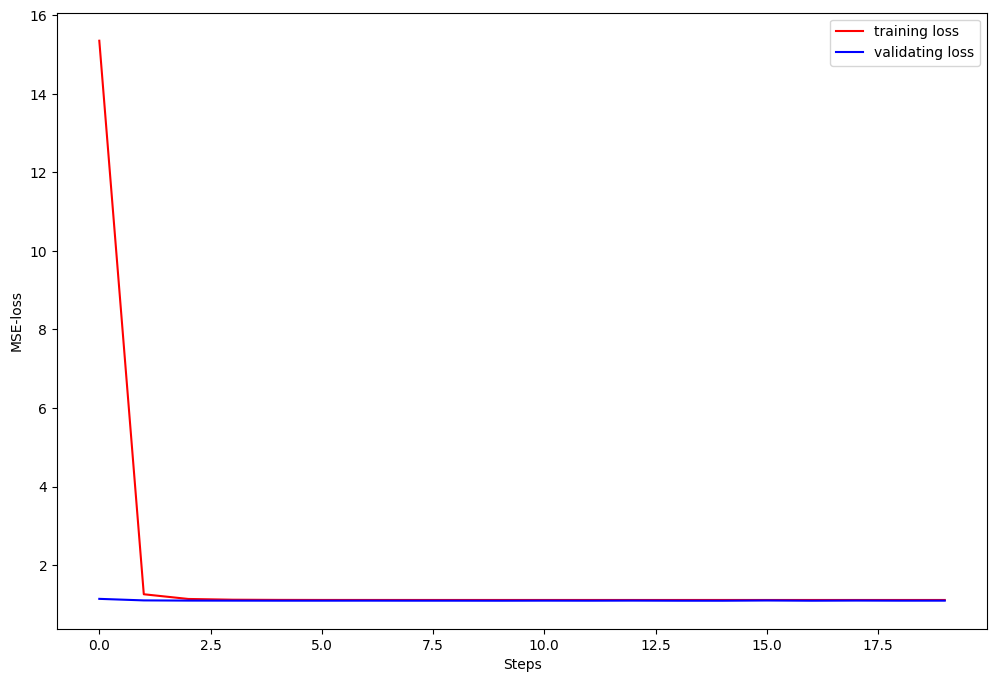

In [ ]:
plt.figure(figsize = (12,8))
plt.plot(np.arange(len(epoches_train_loss)), epoches_train_loss, color='r', label='training loss')
plt.plot(np.arange(len(epoches_dev_loss)), epoches_dev_loss, color='b', label='validating loss')
plt.xlabel('Steps')
plt.ylabel('MSE-loss')
plt.legend()

## **4. Calculate Hit Ratio**

### 4.1 Get predicted label for test

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ae = AE(nb_products = len(df.columns))
ae.load_state_dict(torch.load('/content/drive/MyDrive/BT5153Applied Machine Learning/models/AutoEncoder.pkl'))
ae = ae.to(device)
ae.eval()
recon_list = []
with torch.no_grad():
  for data in test_loader:
    data = data.float().to(device)
    recon_x = ae.forward(data)
    recon_list += list(np.array(recon_x.cpu()))

### 4.2 Recommend unowned products

In [ ]:
nb_movies = len(test.columns)
nb_recommend = 10
recommend_index = []
for i, predict_output in enumerate(recon_list):
  user_input = np.array(test)[i]
  predicted_result = np.vstack([user_input, predict_output])
  recommend = np.array(predicted_result)
  trian_movie_id = np.array([i for i in range(0, nb_movies)])
  recommend = np.row_stack((recommend, trian_movie_id))
  recommend = recommend.T
  recommend = recommend.tolist()

  movie_not_seen = []#delete the rows comtaining the movies that the user had seen
  for i in range(len(recommend)):
      if recommend[i][0] == 0.0:
          movie_not_seen.append(recommend[i])
  movie_not_seen = sorted(movie_not_seen, key=operator.itemgetter(1), reverse=True)
  recommend_movie = []#create list for recommended movies with the index we created
  for i in range(0, nb_recommend):
      recommend_movie.append(movie_not_seen[i][2])
  recommend_index.append(recommend_movie)

### 4.3 Get already owned products

In [ ]:
def flatten(l):
  return [item for sublist in l for item in sublist]

def get_alr_owned_prods(np_owned):
  alr_owned_list = []
  for item in np_owned:
    alr_own = np.argwhere(item != 0)
    alr_own = flatten(alr_own)
    alr_owned_list.append(alr_own)
  return alr_owned_list

alr_owned_list = get_alr_owned_prods(np.array(test))
future_owned_list = get_alr_owned_prods(np.array(test_label))

### 4.4 Get new owned prods

In [ ]:
def get_new_owned_prods(alr_owned_list, future_owned_list):
  new_owned_list = []
  for i in range(len(alr_owned_list)):
    new_owned_list.append([x for x in future_owned_list[i] if x not in alr_owned_list[i]])
  return new_owned_list
new_owned_list = get_new_owned_prods(alr_owned_list, future_owned_list)

### 4.5 Hit Ratio

In [ ]:
index_in_new_and_in_pred = []
for i in range(len(new_owned_list)):
  index_in_new_and_in_pred.append([x for x in new_owned_list[i] if x in recommend_index[i]])
ratio_list = []
for i in range(len(new_owned_list)):
  if len(new_owned_list[i]) == 0:
    ratio_list.append([np.nan])
  else:
    ratio_list.append([len(index_in_new_and_in_pred[i]) / len(new_owned_list[i])])
np.nanmean(flatten(ratio_list))

0.10418535127055306